In [2]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
img = cv2.imread('./test_images/sharapova.jpg')

In [4]:
img.shape

(555, 700, 3)

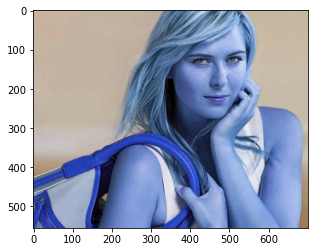

In [5]:
plt.imshow(img)

In [6]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(555, 700)

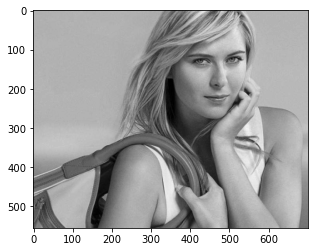

In [7]:
plt.imshow(gray, cmap='gray')

In [8]:
face_cascade =cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

In [9]:
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[352,  38, 233, 233]])

In [10]:
(x,y,w,h) = faces[0]
x,y,w,h

(352, 38, 233, 233)

In [11]:
face_img = cv2.rectangle(img , (x,y), (x+w,y+h), (255,0,0), 2)

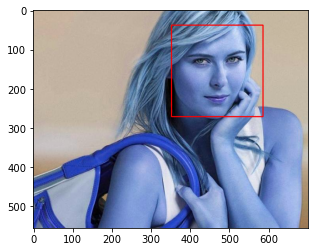

In [12]:
plt.imshow(face_img)

<function matplotlib.pyplot.show(close=None, block=None)>

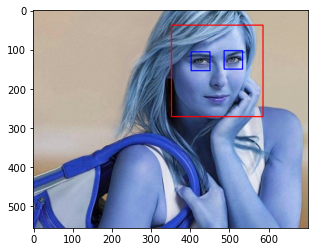

In [13]:
cv2.destroyAllWindows()
for(x,y,w,h) in faces:
    face_img = cv2.rectangle(img , (x,y), (x+w,y+h), (255,0,0), 2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color , (ex,ey), (ex+ew,ey+eh), (0,0,255), 2)
        
plt.figure()
plt.imshow(face_img , cmap = 'gray')
plt.show

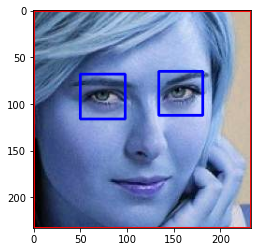

In [14]:
plt.imshow(roi_color , cmap = 'gray')

In [15]:
def get_cropped_image_if_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for(x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

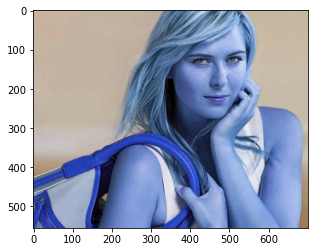

In [16]:
original_image = cv2.imread('./test_images/sharapova.jpg')
plt.imshow(original_image)

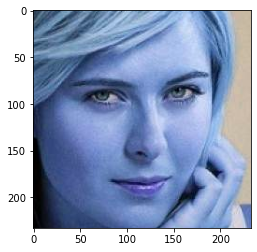

In [41]:
cropped_image = get_cropped_image_if_eyes('./test_images/sharapova.jpg')
plt.imshow(cropped_image)

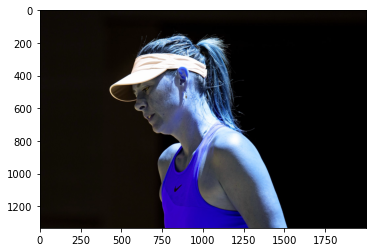

In [18]:
original_image = cv2.imread('./test_images/sharapova3.jpg')
plt.imshow(original_image)

In [44]:
cropped_image2 = get_cropped_image_if_eyes('./test_images/sharapova3.jpg')
cropped_image2

In [45]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

### checking the folder name

In [24]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [25]:
img_dirs

['./dataset/lionel_messi',
 './dataset/maria_sharapova',
 './dataset/roger_federer',
 './dataset/serena_williams',
 './dataset/virat_kohli']

### if exists delete and create new folder

In [26]:
import shutil
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [30]:
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    print(celebrity_name)
    celebrity_file_names_dict[celebrity_name] = []
    
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped folder:" , cropped_folder)
                
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

lionel_messi
Generating cropped folder: ./dataset/cropped/lionel_messi
maria_sharapova
Generating cropped folder: ./dataset/cropped/maria_sharapova
roger_federer
Generating cropped folder: ./dataset/cropped/roger_federer
serena_williams
Generating cropped folder: ./dataset/cropped/serena_williams
virat_kohli
Generating cropped folder: ./dataset/cropped/virat_kohli


In [31]:
import pywt

In [38]:
def w2d(img, mode='haar', level=1):
    src = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    #convert to float
    imArray = np.float32(imArray)
    imArray /= 255
    #compute coefficients
    coeffs = pywt.wavedec2(imArray, mode, level=level)
    
    #Process coefficients
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0;
    
    # reconstruction
    imArray_H = pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H = np.uint8(imArray_H)
    
    return imArray_H

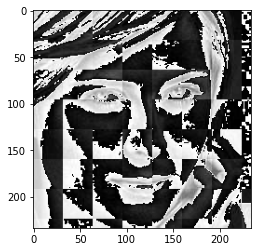

In [43]:
im_har = w2d(cropped_image,'db1',5)
plt.imshow(im_har, cmap = 'gray')

In [46]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 2,
 'serena_williams': 3,
 'virat_kohli': 4}

In [47]:
X = []
y = []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:  #we deleted some images manually
            continue
        scaled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scaled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scaled_raw_img.reshape(32*32*3,1),scaled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])    

In [48]:
len(X[0])

4096

In [50]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(168, 4096)

In [51]:
X[0]

array([100., 129., 140., ..., 238., 232., 230.])

## Model Building

In [54]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [55]:
X_train, X_test,y_train, y_test = train_test_split(X,y, random_state=0)

In [56]:
pipe = Pipeline([('scaler', StandardScaler()),('svc', SVC(kernel='rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test,y_test)

0.9047619047619048

In [57]:
len(X_test)

42

In [58]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.57      0.73         7
           1       1.00      0.90      0.95        10
           2       0.71      1.00      0.83         5
           3       0.90      1.00      0.95         9
           4       0.92      1.00      0.96        11

    accuracy                           0.90        42
   macro avg       0.91      0.89      0.88        42
weighted avg       0.92      0.90      0.90        42



### GridSearch CV

In [59]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [60]:
model_params = {
    'svm':{
        'model': svm.SVC(gamma = 'auto',probability = True),
        'params':{
            'svc__C' :[1,10,100,1000],
            'svc__kernel':['rbf','linear']
        }
        },
    'random_forest':{
        'model': RandomForestClassifier(),
        'params':{
            'randomforestclassifier__n_estimators':[1,5,10]
        }
    },
    'logistic_regression':{
        'model': LogisticRegression(solver='liblinear', multi_class = 'auto'),
        'params':{
            'logisticregression__C':[1,5,10]
        }
    }
}

In [62]:
scores = []
best_estimators = {}
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf = GridSearchCV(pipe, mp['params'], cv =5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores, columns = ['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.833846,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.722154,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.873231,{'logisticregression__C': 1}


In [63]:
best_estimators['svm'].score(X_test, y_test)

0.9523809523809523

In [64]:
best_clf = best_estimators['svm']

In [65]:
from sklearn.metrics import confusion_matrix
cm= confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[ 6,  1,  0,  0,  0],
       [ 0,  9,  0,  1,  0],
       [ 0,  0,  5,  0,  0],
       [ 0,  0,  0,  9,  0],
       [ 0,  0,  0,  0, 11]], dtype=int64)

Text(69.0, 0.5, 'Truth')

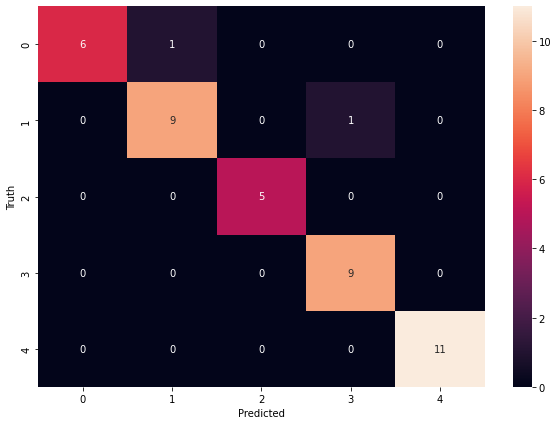

In [67]:
import seaborn as sns
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot = True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [68]:
class_dict

{'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 2,
 'serena_williams': 3,
 'virat_kohli': 4}

### Save the trained model

In [69]:
import joblib

In [70]:
joblib.dump(best_clf, 'saved_model.pkl')

['saved_model.pkl']

### Save class dictionary

In [71]:
import json

In [72]:
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))